# Step 1

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colors
from matplotlib import patches
import proplot as pplt

# Local
sys.path.append('..')
from tools import energyVS06 as energy
from tools.plotting import plot_profiles
from tools.plotting import plot_image
from tools.plotting import plot_compare_images
from tools import image_processing as ip
from tools.utils import get_bins
from tools.utils import project
from tools import utils

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

In [3]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29/'
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [4]:
filename = '220429190854-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('All attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

All attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (12524,))), 0))



In [5]:
acts = data_sc.dtype.names[:3]
print('Actuators:')
print(acts)

print('Scalar diagnostics:')
sdiag = data_sc.dtype.names[3:6]
print(sdiag)

Actuators:
('x_PositionSync', 'xp_PositionSync', 'y_PositionSync')
Scalar diagnostics:
('bcm04', 'cam34_Integral', 'cam34_Saturation')


In [6]:
cam = 'cam34'
signal = np.copy(data_sc[:, cam + '_Integral'])
ipeak = np.argmax(signal)
print('Index of peak signal:', ipeak)

Index of peak signal: 31474


### Mask BCM current

Average BCM current (before masking) = -29.828 +- 0.223 [mA]
idx_mask: [41812 41813]
2 points masked due to BCM current < 25.000 [mA]
Average BCM current (after masking) = -29.829 +- 0.103 [mA]
New index of peak signal = 31474


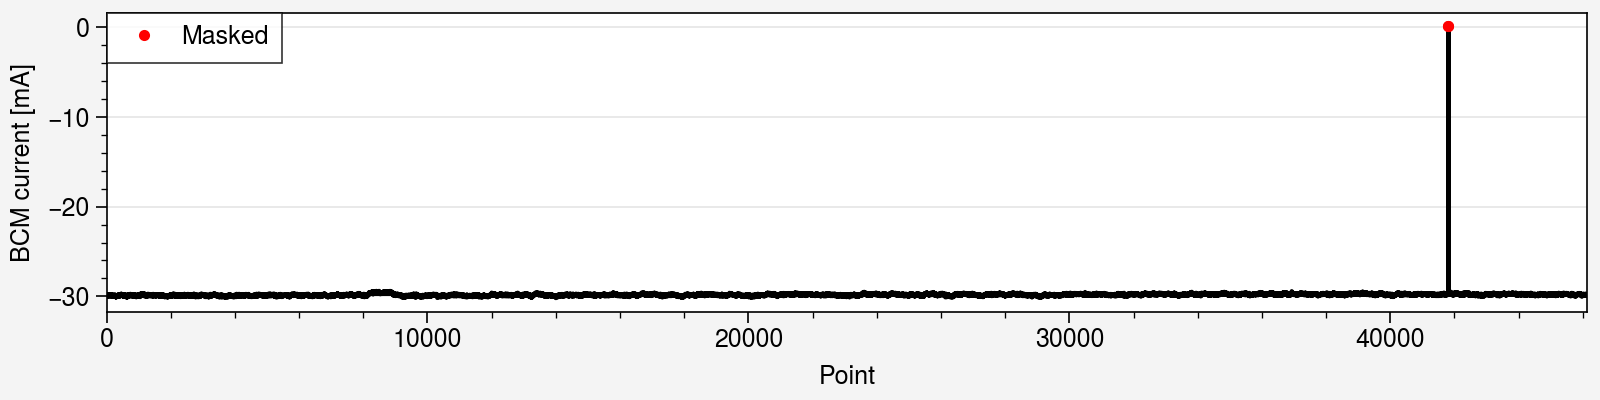

In [7]:
# Gather the BCM data.
pv = 'bcm04'
bcm_data = data_sc[pv]
idx = np.arange(len(data))
times = [datetime.fromtimestamp(data_sc[i, 'timestamp']) for i in idx]
times = np.array(times)
print(f'Average BCM current (before masking) = {np.mean(bcm_data):.3f} +- {np.std(bcm_data):.3f} [mA]')

# Mask any low-current points.
bcm_limit = 25.0  # [mA]
idx_mask, = np.where(bcm_data > -bcm_limit)
idx_valid, = np.where(~np.isin(idx, idx_mask))
print('idx_mask:', idx_mask)
print(f'{len(idx_mask)} points masked due to BCM current < {bcm_limit:.3f} [mA]')
print(f'Average BCM current (after masking) = {np.mean(bcm_data[idx_valid]):.3f} +- {np.std(bcm_data[idx_valid]):.3f} [mA]')

# After masking, reselect the index of the peak signal.
ipeak = idx_valid[np.argmax(signal[idx_valid])]
print('New index of peak signal =', ipeak)

# Plot the BCM current during the scan, along with masked points.
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.plot(bcm_data[idx], color='black')
ax.plot(idx_mask, bcm_data[idx_mask], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
plt.show()

### Fit slit scan correlations

In [8]:
corr = np.identity(len(acts))
intercept = np.zeros(corr.shape)
for i, act1 in enumerate(acts):
    for j, act2 in enumerate(acts):
        fit1d = np.polyfit(data_sc[:, act1], data_sc[:, act2], 1, w=signal)
        print(f'{act2} vs. {act1}: slope = {fit1d[0]:.3f}')
        corr[i, j] = fit1d[0]
        intercept[i, j] = fit1d[1]
print('Correlation matrix:')
print(corr)

x_PositionSync vs. x_PositionSync: slope = 1.000
xp_PositionSync vs. x_PositionSync: slope = 1.844
y_PositionSync vs. x_PositionSync: slope = -0.007
x_PositionSync vs. xp_PositionSync: slope = 0.375
xp_PositionSync vs. xp_PositionSync: slope = 1.000
y_PositionSync vs. xp_PositionSync: slope = -0.006
x_PositionSync vs. y_PositionSync: slope = -0.009
xp_PositionSync vs. y_PositionSync: slope = -0.035
y_PositionSync vs. y_PositionSync: slope = 1.000
Correlation matrix:
[[ 1.          1.84387349 -0.00723158]
 [ 0.37530962  1.         -0.00575115]
 [-0.00899123 -0.03513029  1.        ]]


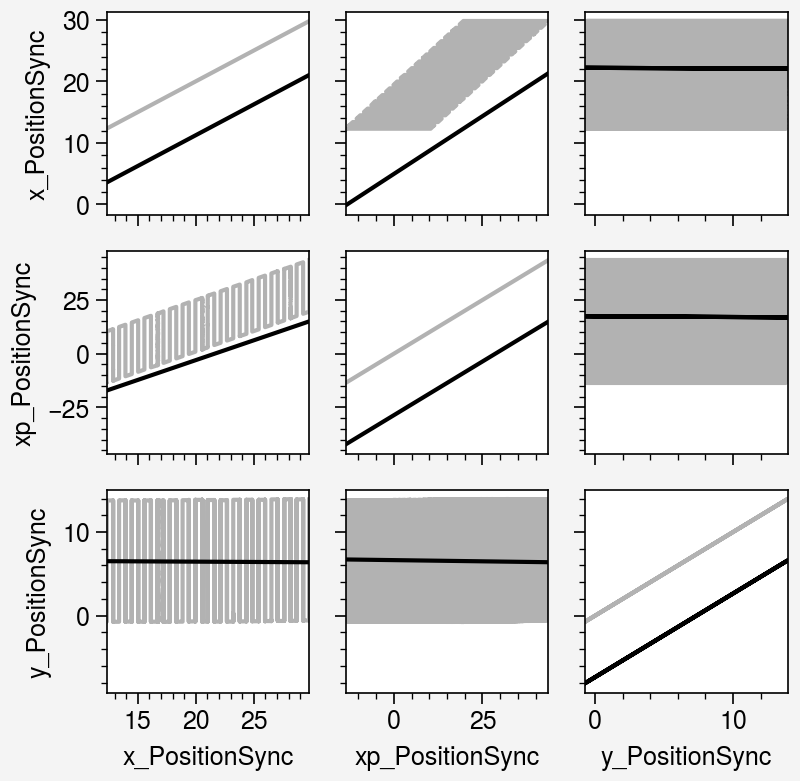

In [9]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=4.0, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        x = data_sc[acts[j]]
        y = data_sc[acts[i]]
        ax.plot(x, y, color='black', alpha=0.3)
        xmin, xmax = np.min(x), np.max(x)
        _x = x - 0.5 * (xmax - xmin)
        _y = corr[j, i] * _x + intercept[j, i]
        ax.plot(x, _y, color='black')
for i, act in enumerate(acts):
    axes[-1, i].set_xlabel(act)
    axes[i, 0].set_ylabel(act)
plt.show()

Work in the "normalized" (decorrelated) slit-screen coordinates. First, try transforming back to square grid.

In [10]:
# Shearing matrix 
ndim = 3
M = np.identity(ndim)
M[1, 2] = 1.9  # dxp / dx
Minv = np.linalg.inv(M)

# y
d1_center = 6.5
d1_distance = 14.5
d1_steps = 32

# xp
d2_center = 15.0
d2_distance = 24.0
d2_steps = 32

# x
d3_center = 21.0
d3_distance = 17.5
d3_steps = 32

center = np.array([d1_center, d2_center, d3_center])

Test on CSV file (planned points).

In [11]:
names = []
for i in range(1, ndim + 1):
    names.extend([f'start{i}', f'stop{i}', f'step{i}'])
df = pd.read_csv(join(datadir, filename + '.csv'), 
                 skiprows=25, sep='\s+', header=None, names=names)
df

,start1,stop1,step1,start2,stop2,step2,start3,stop3,step3
2,-0.75,13.75,2.266,-12.125,-12.125,0.0,12.25,12.25,0.0
3,13.75,-0.75,2.266,-11.375,-11.375,0.0,12.25,12.25,0.0
4,-0.75,13.75,2.266,-10.625,-10.625,0.0,12.25,12.25,0.0
5,13.75,-0.75,2.266,-9.875,-9.875,0.0,12.25,12.25,0.0
6,-0.75,13.75,2.266,-9.125,-9.125,0.0,12.25,12.25,0.0
...,...,...,...,...,...,...,...,...,...
1084,-0.75,13.75,2.266,40.625,40.625,0.0,29.75,29.75,0.0
1085,13.75,-0.75,2.266,41.375,41.375,0.0,29.75,29.75,0.0
1086,-0.75,13.75,2.266,42.125,42.125,0.0,29.75,29.75,0.0
1087,13.75,-0.75,2.266,42.875,42.875,0.0,29.75,29.75,0.0


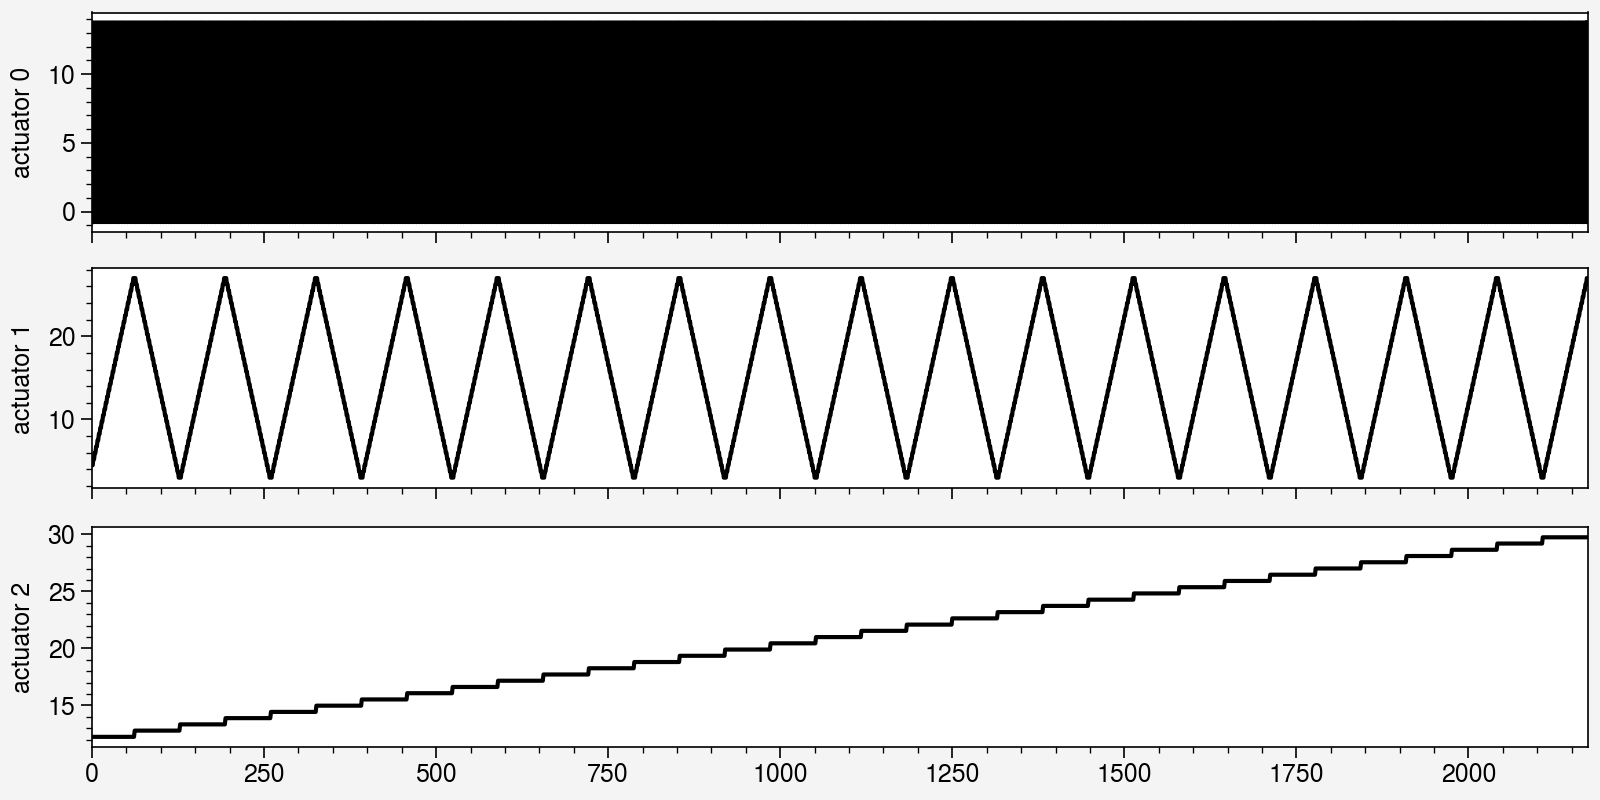

In [12]:
# Extract actuator points.
act_pts = [df.loc[:, [f'start{i}', f'stop{i}']].values.ravel() 
           for i in range(1, ndim + 1)]
act_pts = np.array(act_pts).T

# Undo linear transformation.
act_pts_n = np.apply_along_axis(lambda pt: np.matmul(Minv, pt - center) + center, 1, act_pts)

# Plot actuator points in "normalized" space.
fig, axes = pplt.subplots(nrows=3, figsize=(8.0, 4.0), spany=False, aligny=True)
for i, ax in enumerate(axes):
    ax.plot(act_pts_n[:, i], color='black', lw=None, marker='.', ms=0)
    ax.format(ylabel=f'actuator {i}')
# plt.savefig('_output/actuators')

Create dataframe of actuator points.

In [13]:
dim_names = ['y1', 'x2', 'x1']
columns = []
for i, dim_name in enumerate(dim_names):
    columns.extend([dim_name, dim_name + '_n'])
df2 = pd.DataFrame(index=df.index, columns=columns)
for i, dim_name in enumerate(dim_names):
    df2[dim_name] = act_pts[::2, i]
    df2[dim_name + '_n'] = act_pts_n[::2, i]
df2

,y1,y1_n,x2,x2_n,x1,x1_n
2,-0.75,-0.75,-12.125,4.50,12.25,12.25
3,13.75,13.75,-11.375,5.25,12.25,12.25
4,-0.75,-0.75,-10.625,6.00,12.25,12.25
5,13.75,13.75,-9.875,6.75,12.25,12.25
6,-0.75,-0.75,-9.125,7.50,12.25,12.25
...,...,...,...,...,...,...
1084,-0.75,-0.75,40.625,24.00,29.75,29.75
1085,13.75,13.75,41.375,24.75,29.75,29.75
1086,-0.75,-0.75,42.125,25.50,29.75,29.75
1087,13.75,13.75,42.875,26.25,29.75,29.75


## Interpolation 

### Procedure for one bin

#### Group by (x, x') for a specified bin index

In [14]:
nstep = 21 
GV = []  # Bin positions
BI = []  # Bin indices
for i, dim_name in enumerate(dim_names):
    gv, idx = get_bins(act_pts_n, i, nstep, n_bins_mult=15)
    GV.append(gv)
    BI.append(idx)
    print(f'{dim_name}: {len(gv)} bins')

y1: 2 bins
x2: 33 bins
x1: 33 bins


In [15]:
# fig, axes = pplt.subplots(nrows=3, figsize=(8, 7), spany=False)
# for i, (ax, dim_name) in enumerate(zip(axes, dim_names)):
#     ax.plot(act_pts_n[:, i], marker='.', color='black', ms=3, lw=0)
#     ax.format(ylabel=dim_name, yticks=GV[i], ygrid=True, ytickminor=False, yticklabels=[])
# plt.show()

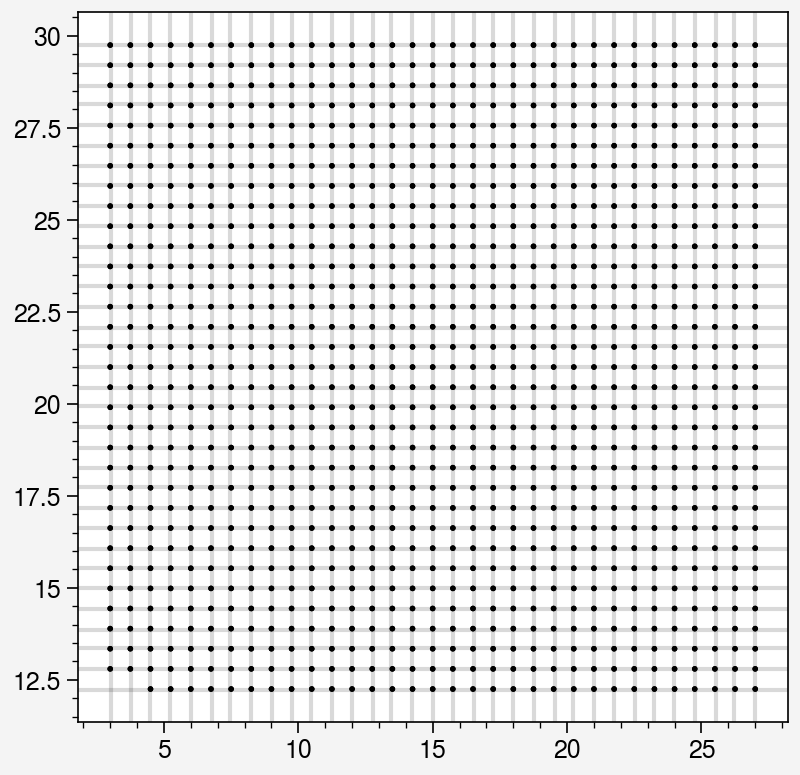

In [16]:
GV2, GV1 = np.meshgrid(GV[2], GV[1], indexing='ij')

fig, ax = pplt.subplots(figwidth=4.0)
kws = dict(color='black', alpha=0.15)
for gv in GV[1]:
    ax.axvline(gv, **kws)
for gv in GV[2]:
    ax.axhline(gv, **kws)
ax.scatter(act_pts_n[:, 1], act_pts_n[:, 2], c='black', s=4, ec='None'); 
plt.show()

#### Group by (x, x') coordinates

In [17]:
# POINTS2D holds iteration number on x1-x2 grid (total iterations = 1/2 total sweeps)
# ordering: y, xp, x, yp, I
POINTS2D = np.full((len(GV[2]), len(GV[1])), np.nan)
counter = 1
steps = [0]
for i in range(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        idx, = np.where((BI[1] == j) & (BI[2] == i))
        if len(idx) > 0:
            steps.append(idx)
            POINTS2D[i, j] = counter
        else:
            print(f'Bin {i},{j} empty')
        counter += 1
POINTS2D = POINTS2D.astype(int)

Bin 0,0 empty
Bin 0,1 empty


In [18]:
idx_bin = []
for i, step in enumerate(steps):
    this_iter = np.unique(step / 2 + 1)
    if type(this_iter) is float:
        this_iter = np.array([this_iter])
    this_iter = this_iter.astype(int)
    idx_i = []
    for j in this_iter:
        this_idx, = np.where(data_sc['iteration'] == j)
        idx_i.append(this_idx)
    idx_bin.append(np.unique(np.hstack(idx_i)))

### Look at a single bin

In [19]:
iteration_peak, n_iterations = None, len(steps)
for iteration in range(n_iterations):
    if ipeak in idx_bin[iteration]:
        iteration_peak = iteration
        print(f'Peak is in iteration {iteration}')

Peak is in iteration 743


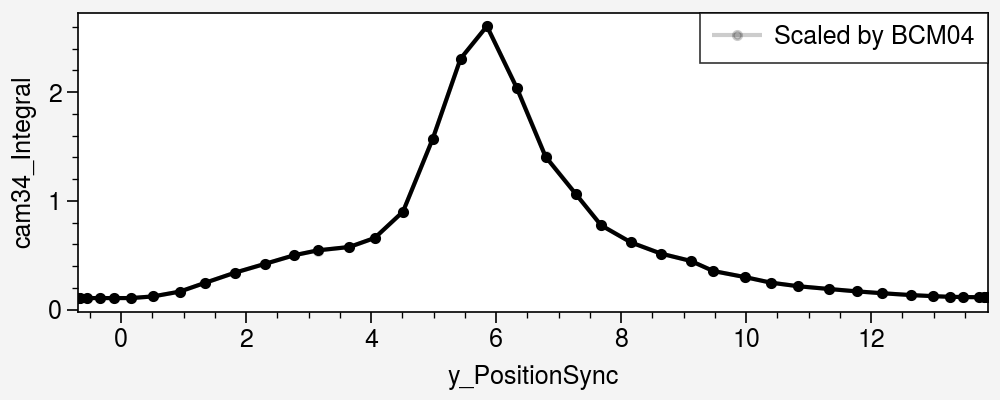

In [20]:
iteration = iteration_peak
bcm_mean = np.mean(data_sc[:, 'bcm04'])
scale = bcm_mean / data_sc[idx_bin[iteration], 'bcm04']

fig, ax = pplt.subplots(figsize=(5.0, 2))
ax.plot(
    data_sc[idx_bin[iteration], 'y_PositionSync'],
    data_sc[idx_bin[iteration], cam + '_Integral'],
    color='black', marker='.',
)
ax.plot(
    data_sc[idx_bin[iteration], 'y_PositionSync'],
    data_sc[idx_bin[iteration], cam + '_Integral'] * scale,
    color='black', marker='.', alpha=0.2,
    label='Scaled by BCM04',
)
ax.legend(loc='upper right')
ax.format(xlabel='y_PositionSync', ylabel=cam+'_Integral')
plt.show()

### Make GIF of sweep

We should either store the image in a square array in step 0, or somehow pass the new image shape to this notebook.

In [21]:
ny, nx = (101, 124)  # processed image size

def get_image(index):
    return data_im[index, cam + '_Image'].reshape(ny, nx)

In [22]:
i_peak_sweep = np.argmax(data_sc[idx_bin[iteration], cam + '_Integral'])
norm_pixel_value = np.max(data_im[idx_bin[iteration][i_peak_sweep], cam + '_Image'])
cmap = pplt.Colormap('dusk_r')
greyscale = False
log = False

_ims = []
for i in tqdm(idx_bin[iteration]):
    _im = get_image(i) / norm_pixel_value
    if log:
        _im = np.log10(_im)
    if not greyscale:
        _im = cmap(_im)
    _ims.append(np.uint8(_im * np.iinfo(np.uint8).max))
imageio.mimsave(f'_output/iteration{iteration}.gif', _ims, fps=6)

100%|██████████| 43/43 [00:00<00:00, 1744.04it/s]


### Construct background image

This is done by collecting frames around the edge of the image. (This is not used anywhere in the analysis.)

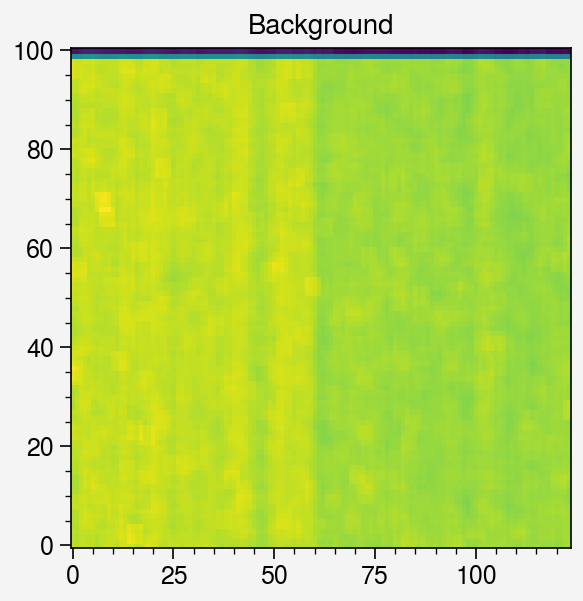

In [23]:
n_bins = 32
edge_bins = np.arange(n_bins + 1, (n_bins + 1) * (n_bins + 1), n_bins + 1)
im_edge = np.zeros((ny, nx))
im_bg = np.zeros((edge_bins.shape[0], ny, nx))
for i, edge_bin in enumerate(edge_bins):
    nframes = len(idx_bin[edge_bin])
    im3d = np.zeros((nframes, ny, nx))
    for j in range(nframes):
        im3d[j, :, :] = get_image(idx_bin[edge_bin][j])
    im_bg[i, :, :] = np.mean(im3d, axis=0)
im_bg = np.mean(im_bg, axis=0)
im_bg = ndimage.uniform_filter(im_bg, size=(4, 4), mode='nearest')

fig, ax = pplt.subplots()
ax.pcolormesh(im_bg)
ax.format(title='Background')
plt.show()

### Smooth and interpolate along y_PositionSync 

We have snapped all points onto an x1-x2 grid. What remains is to interpolate the y1 coordinate — the sweeping variable. We will do this by applying a filter to the 3D image. (We are still looking at a single iteration here.)

In [24]:
# Make the 3D image. 
iteration = iteration_peak
n_frames = len(idx_bin[iteration])
im3d = np.zeros((n_frames, ny, nx))
for i in trange(n_frames):
    im3d[i, :, :] = get_image(idx_bin[iteration][i])
    
# Get y slit position at each frame.
yvals = data_sc[:, 'y_PositionSync'][idx_bin[iteration]]

# Apply a smoothing filter along the first dimension (y_PositionSync). We can do the same for 
# the camera dimensions; the time cost is the same.
im3d_smooth = ndimage.median_filter(im3d, size=(3, 1, 1), mode='constant', cval=0.0) 

100%|██████████| 43/43 [00:00<00:00, 6583.98it/s]


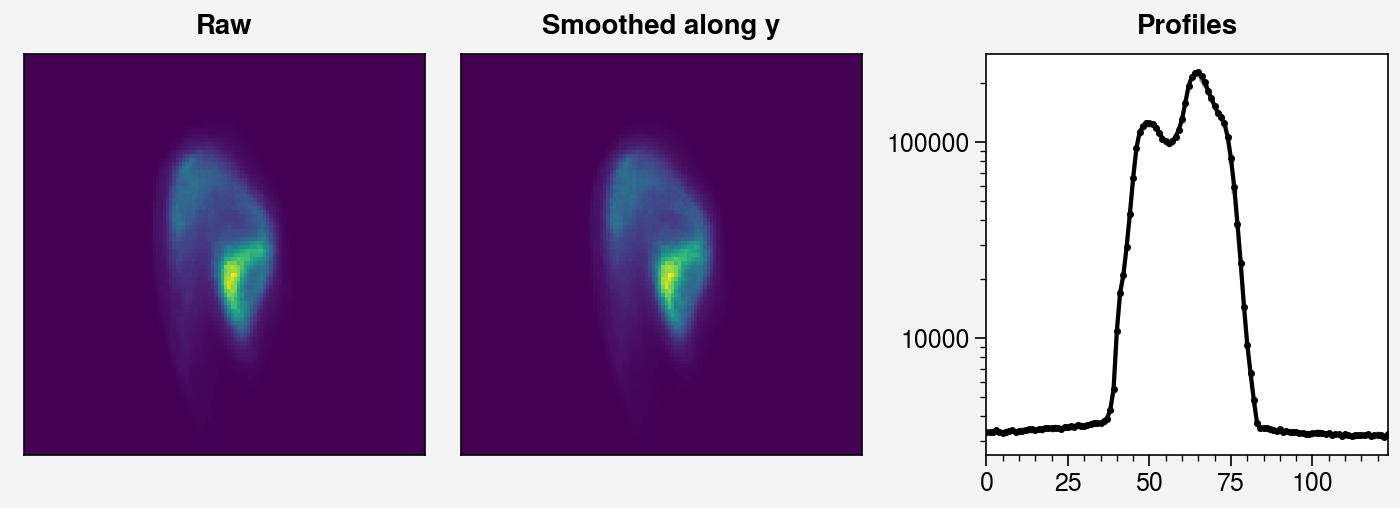

In [25]:
i = 25

fig, axes = pplt.subplots(ncols=3, figwidth=7, sharey=False)
axes[0].pcolormesh(im3d[i, :, :])
axes[1].pcolormesh(im3d_smooth[i, :, :])
axes[2].plot(np.sum(im3d[i, :, :], axis=0), color='black', marker='.', ms=3)
axes[2].plot(np.sum(im3d_smooth[i, :, :], axis=0), color='black', marker='.', ms=3, alpha=0.2)
axes.format(toplabels=['Raw', 'Smoothed along y', 'Profiles'])
axes[:-1].format(xticks=[], yticks=[])
axes[-1].format(yscale='log')
plt.show()

### Interpolate to y grid

In [26]:
npts_y = 32  # number of points in y grid
ygv = np.linspace(np.min(yvals), np.max(yvals), npts_y)  # y grid values

# Deal with backwards-moving slit.
if yvals[0] > yvals[-1]:
    yvals = np.flip(yvals)
    im3d_smooth = np.flip(im3d_smooth, axis=0)
    im3d = np.flip(im3d, axis=0)
    
# Deal with any repeating points (otherwise interpolation will not work).
repeat_idx, = np.where(np.diff(yvals) == 0.0)
counter = 1
for i in reversed(repeat_idx):
    yvals[i] -= counter * 1e-7
    counter += 1
    
# Interpolate.
ypix = np.arange(ny) 
xpix = np.arange(nx)  
yf, ypf, xf = np.meshgrid(ygv, ypix, xpix, indexing='ij')
newpoints = np.vstack([yf.ravel(), ypf.ravel(), xf.ravel()]).T
arr3d = interpolate.interpn(
    (yvals, ypix, xpix), 
    im3d_smooth, 
    newpoints, 
    method='linear', 
    bounds_error=False, 
    fill_value=0.0
)
arr3d = arr3d.reshape(npts_y, ny, nx)

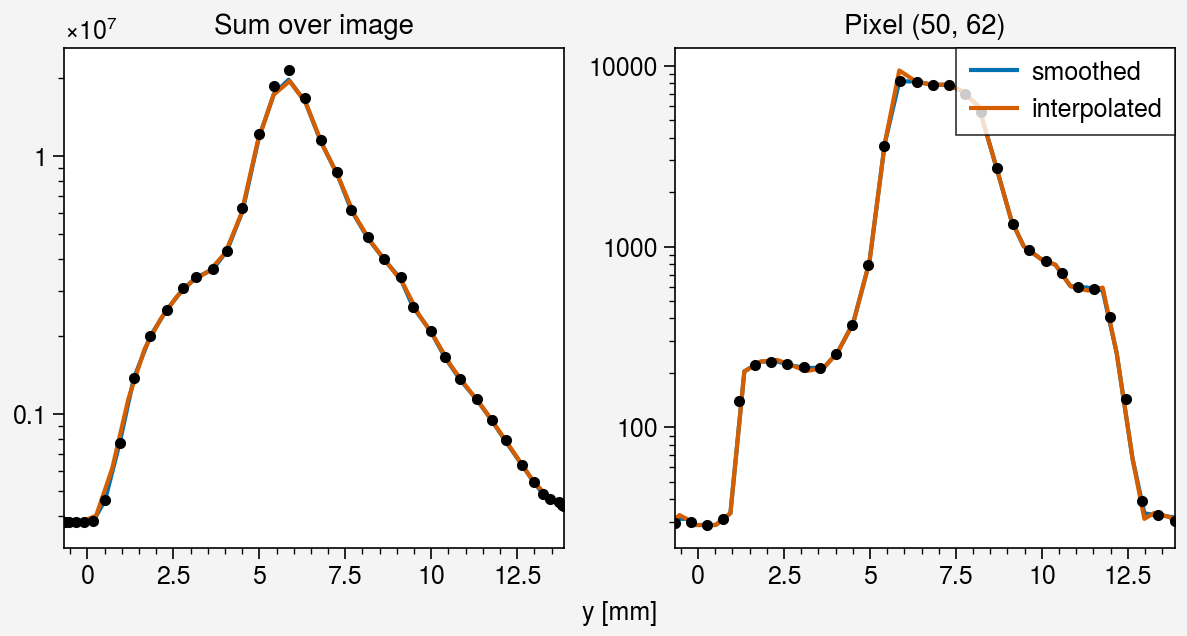

In [27]:
row, col = ny // 2, nx //2

fig, axes = pplt.subplots(ncols=2, sharey=False,)
axes[0].plot(yvals, project(im3d_smooth, 0), label='smoothed')
axes[0].plot(ygv, project(arr3d, 0), label='interpolated')
axes[0].plot(yvals, project(im3d, 0), marker='.', lw=0, color='black')
# ax.legend(loc='upper right', ncol=1,)
axes[1].plot(yvals, im3d_smooth[:, row, col], label='smoothed')
axes[1].plot(yvals, im3d[:, row, col], label='interpolated')
axes[1].plot(ygv, arr3d[:, row, col], marker='.', lw=0, color='black')
axes.format(yscale='log', xlabel='y [mm]')
axes[1].legend(loc='upper right', ncol=1,)
axes[0].format(title=f'Sum over image')
axes[1].format(title=f'Pixel ({row}, {col})')
plt.show()

Find the frame with the maximum pixel.

In [28]:
max1 = np.unravel_index(np.argmax(im3d), im3d.shape)[0]
max2 = 1 + np.unravel_index(np.argmax(arr3d), arr3d.shape)[0]  # why + 1?
row1, col1 = utils.max_indices(im3d[max1, :, :])
row2, col2 = utils.max_indices(arr3d[max2, :, :])
print(f'max1, row1, col1 = ({max1}, {row1}, {col1})')
print(f'max2, row2, col2 = ({max2}, {row2}, {col2})')

max1, row1, col1 = (20, 40, 50)
max2, row2, col2 = (14, 39, 51)


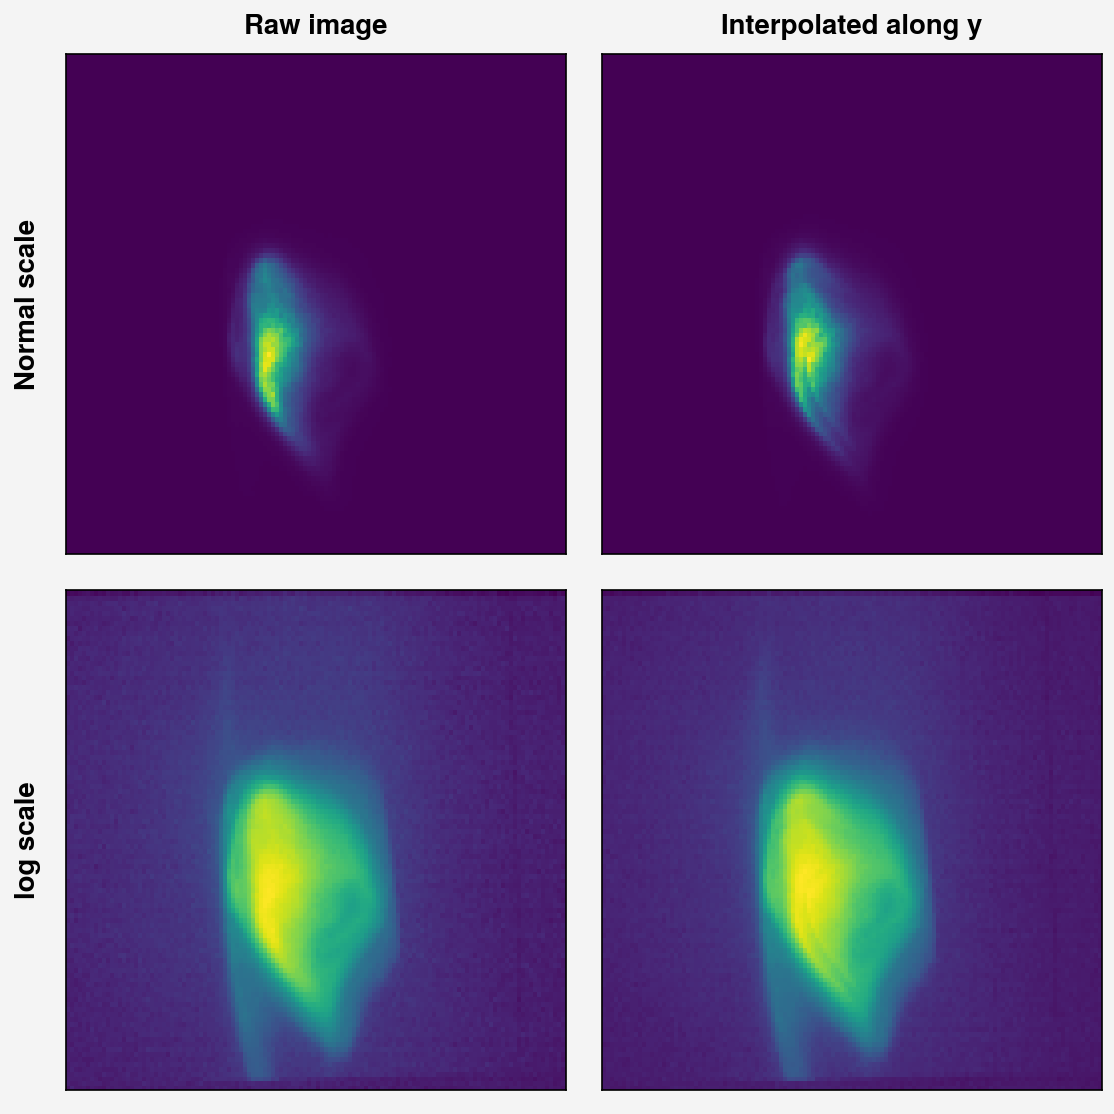

In [29]:
axes = plot_compare_images(im3d[max1], arr3d[max2])
axes.format(toplabels=['Raw image', 'Interpolated along y'])

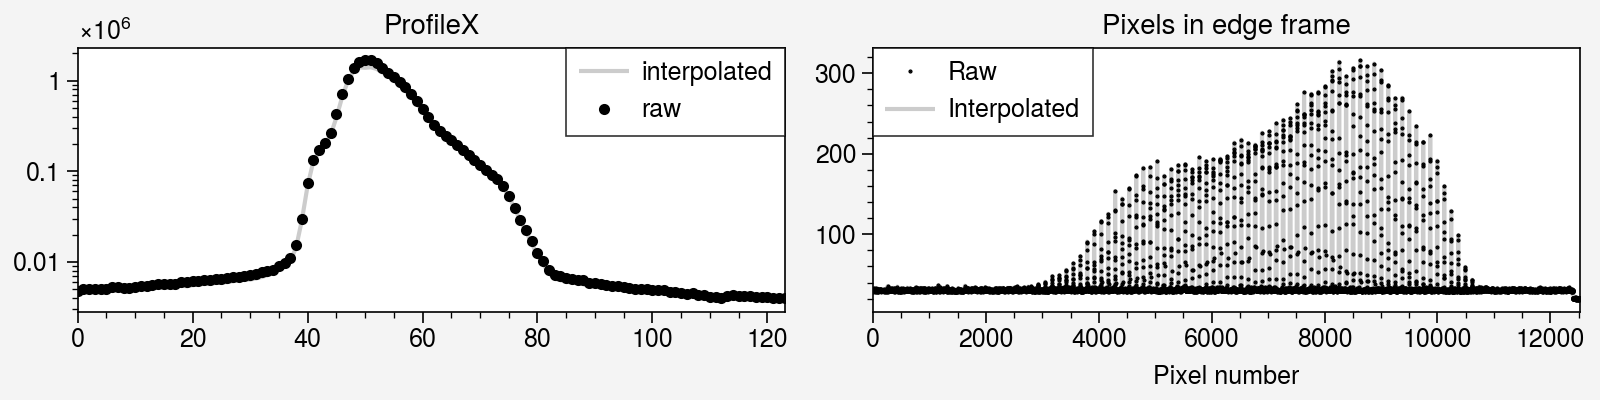

In [30]:
fig, axes = pplt.subplots(ncols=2, sharey=False, spanx=False, figsize=(8, 2))
axes[0].plot(np.sum(arr3d[max2, :, :], axis=0), color='black', alpha=0.2, label='interpolated')
axes[0].plot(np.sum(im3d[max1, :, :], axis=0), marker='.', lw=0, color='black', label='raw')
axes[0].legend(ncol=1)
axes[0].format(yscale='log', title='ProfileX')
axes[1].plot(arr3d[-2, :, :].ravel(), marker='.', lw=0, color='black', ms=1, label='Raw')
axes[1].plot(arr3d[-2, :, :].ravel(), color='black', alpha=0.2, label='Interpolated')
axes[1].legend(loc='upper left', ncols=1)
axes[1].format(title='Pixels in edge frame', xlabel='Pixel number')

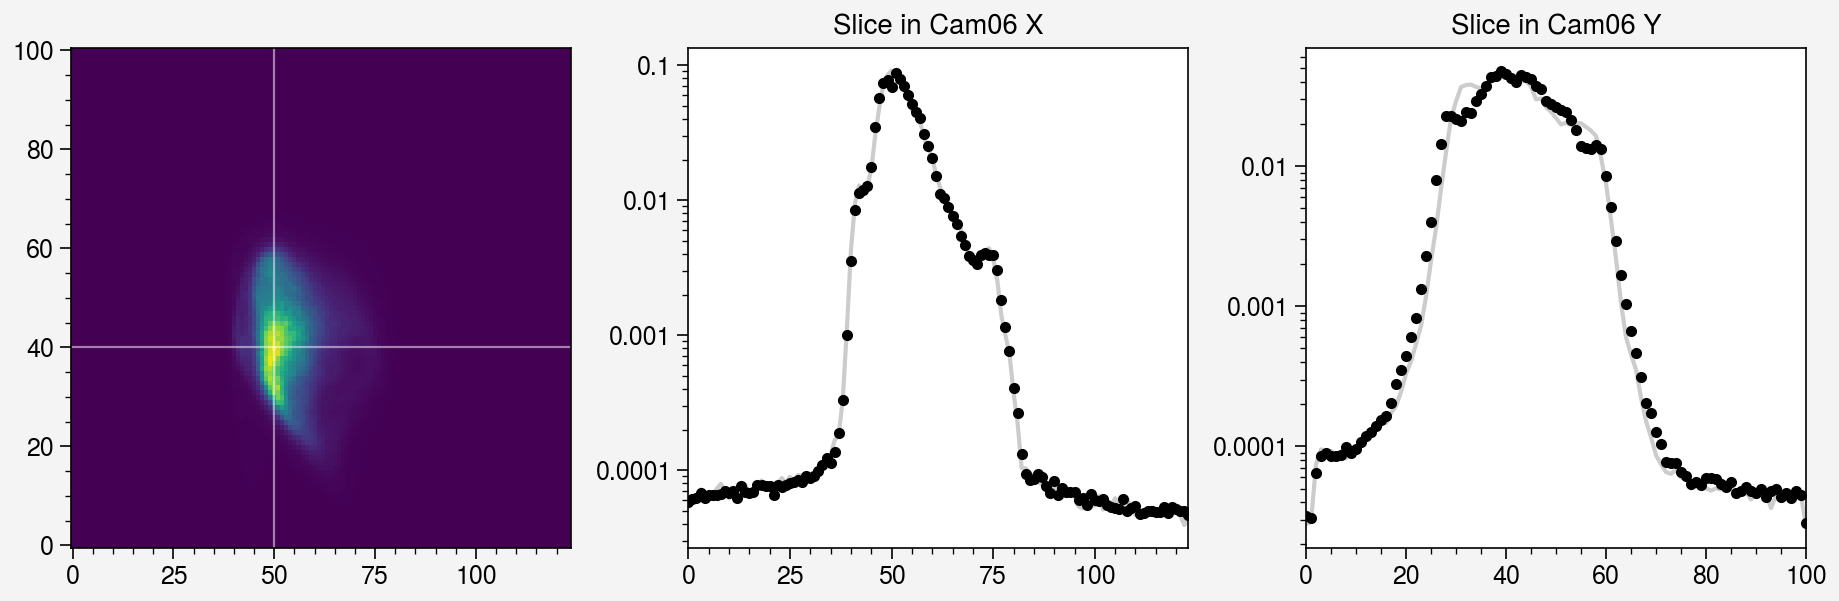

In [31]:
fig, axes = pplt.subplots(ncols=3, sharey=False, sharex=False)
axes[0].pcolormesh(im3d[max1, :, :])
kws = dict(color='white', lw=0.785, alpha=0.5)
axes[0].axvline(col1, **kws)
axes[0].axhline(row1, **kws)
kws = dict(marker='.', color='black')
for im, row, col, flag in zip([arr3d[max2], im3d[max1]], [row2, row1], [col2, col1], [True, False]):
    if flag:
        kws['alpha'] = 1.0
        kws['lw'] = 0.0
    else:
        kws['alpha'] = 0.2
        kws['lw'] = None
        kws['ms'] = 0.0
    axes[1].plot(im[row, :] / np.sum(im[row, :]), **kws)
    axes[2].plot(im[:, col] / np.sum(im[:, col]), **kws)
axes[1].set_title('Slice in Cam06 X')
axes[2].set_title('Slice in Cam06 Y')
axes[1:].format(yscale='log')

## Save slit coordinates

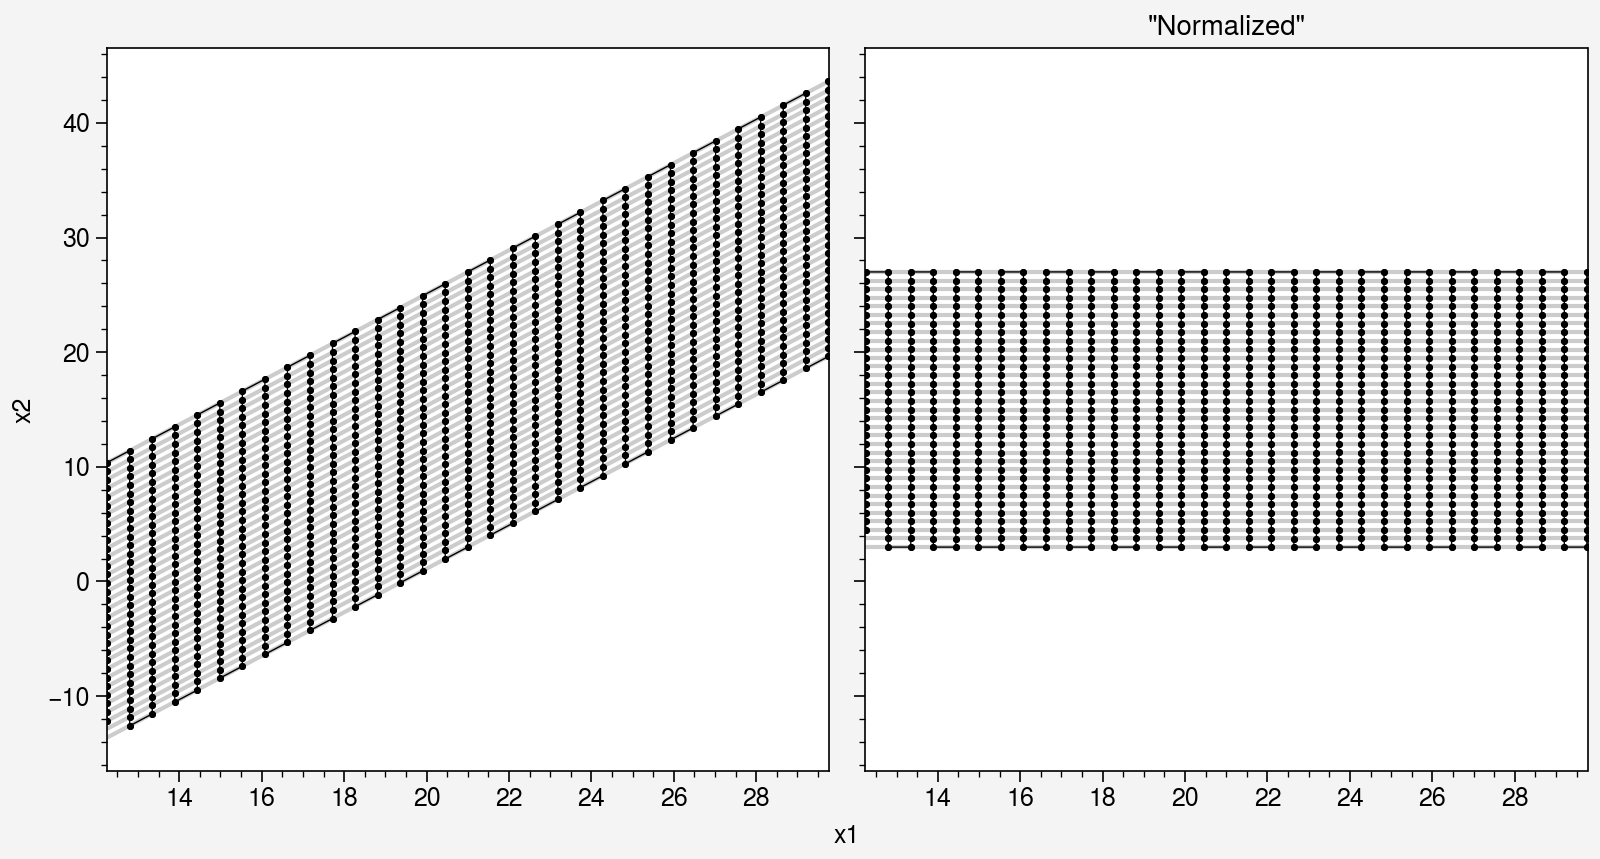

In [32]:
# ordering: y, xp, x
xp_x_n = np.vstack([GV1.ravel(), GV2.ravel()]).T
xp_x = np.apply_along_axis(lambda pt: np.matmul(M[1:, 1:], pt - center[1:]) + center[1:], 1, xp_x_n)
GV_XP_n = xp_x_n[:, 0].reshape(GV1.shape)
GV_X_n = xp_x_n[:, 1].reshape(GV2.shape)
GV_XP = xp_x[:, 0].reshape(GV1.shape)
GV_X = xp_x[:, 1].reshape(GV2.shape)

fig, axes = pplt.subplots(ncols=2, figwidth=8)
for ax, (g1, g2), pts in zip(axes, [(GV_X, GV_XP), (GV_X_n, GV_XP_n)], [act_pts, act_pts_n]):
    ax.plot(g1[:], g2[:], color='black', alpha=0.2)
    ax.plot(pts[:, 2], pts[:, 1], color='black', marker='.', ms=3, lw=0.5)
axes.format(xlabel='x1', ylabel='x2')
axes[1].format(title='"Normalized"')

Define y grid.

In [33]:
y = data_sc[:, 'y_PositionSync']
ygrid = np.linspace(np.min(y), np.max(y), npts_y)

In [34]:
X = np.repeat(GV_X[:, :, np.newaxis], npts_y, axis=2)
XP = np.repeat(GV_XP[:, :, np.newaxis], npts_y, axis=2)
Y = np.zeros(X.shape)
for i in range(len(GV[2])):
    for j in range(len(GV[1])):
        Y[i, j, :] = ygrid

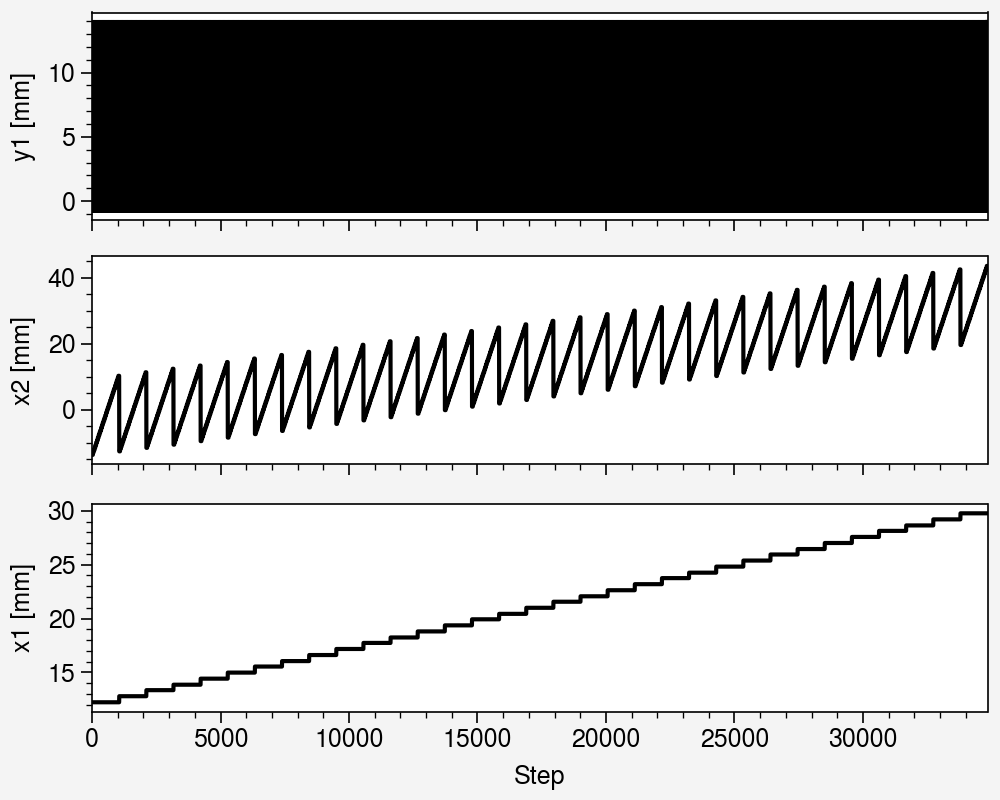

In [35]:
fig, axes = pplt.subplots(nrows=3, figsize=(5, 4), spany=False, aligny=True)
for ax, G, ylabel in zip(axes, [Y, XP, X], ["y1 [mm]", "x2 [mm]", "x1 [mm]"]):
    ax.plot(G.ravel(), color='black')
    ax.format(ylabel=ylabel)
axes.format(xlabel='Step')

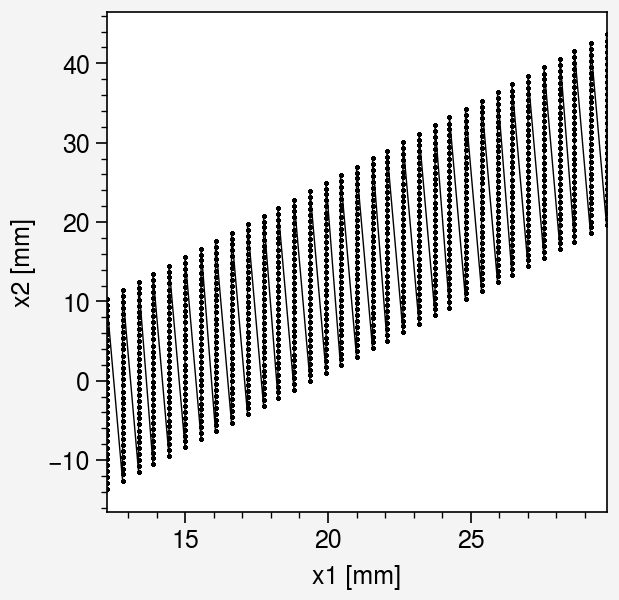

In [36]:
fig, ax = pplt.subplots()
ax.plot(X.ravel(), XP.ravel(), color='black', marker='.', ms=1, lw=0.5)
ax.format(xlabel='x1 [mm]', ylabel='x2 [mm]')

In [37]:
coord_3d = np.stack([X, XP, Y], axis=0)
print(f'coord_3d.shape = {coord_3d.shape}')

coord_3d.shape = (3, 33, 33, 32)


In [38]:
savefilename = f'slit_coordinates_{filename}.npy'
np.save(savefilename, coord_3d)

### Make a function that does all the above

In [86]:
def get_image_3d(idx, ygv, ny, nx, smooth=False):
    ypix = np.arange(ny)
    xpix = np.arange(nx)
    # Build up the 3D image (camera image for every data-point in one sweep).
    n_frames = len(idx)
    im3d = np.zeros((n_frames, ny, nx))
    for i in range(n_frames):
        im3d[i, :, :] = get_image(idx[i])
    # Sort by increasing y value (needed for interpolation)
    yvals = data_sc[:,'y_PositionSync'][idx]
    idx_sort = np.argsort(yvals)
    yvals = yvals[idx_sort]
    im3d = im3d[idx_sort, :, :]
    # Deal with any repeating points (otherwise interpolate won't work)
    yvals = utils.avoid_repeats(yvals, pad=1e-7)
    # Apply filter along 1st dimension (y_PositionSync).
    im3d_smooth = im3d
    if smooth:
        im3d_smooth = ndimage.median_filter(im3d, size=(3,1,1), mode='nearest')
    # Interpolate
    Y, YP, X = np.meshgrid(ygv, ypix, xpix, indexing='ij')
    newpoints = np.vstack([Y.ravel(), YP.ravel(), X.ravel()]).T
    a3d = interpolate.interpn(
        (yvals, ypix, xpix), 
        im3d_smooth, 
        newpoints, 
        method='linear', 
        bounds_error=False, 
        fill_value=0.0
    )   
    return a3d.reshape(npts_y, ny, nx)

In [101]:
iteration = iteration_peak
idx = idx_bin[iteration]
a3d = get_image_3d(idx, ygrid, ny, nx)

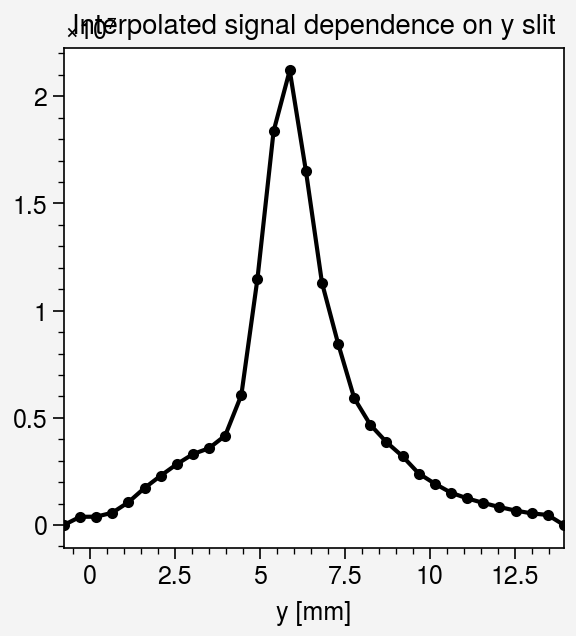

In [102]:
fig, ax = pplt.subplots()
ax.plot(ygrid, utils.project(a3d, 0), marker='.', color='black')
ax.format(xlabel='y [mm]', title='Interpolated signal dependence on y slit')

## View projections and slices of data points in this iteration (sweep). 
coordinates y1, y3, x3

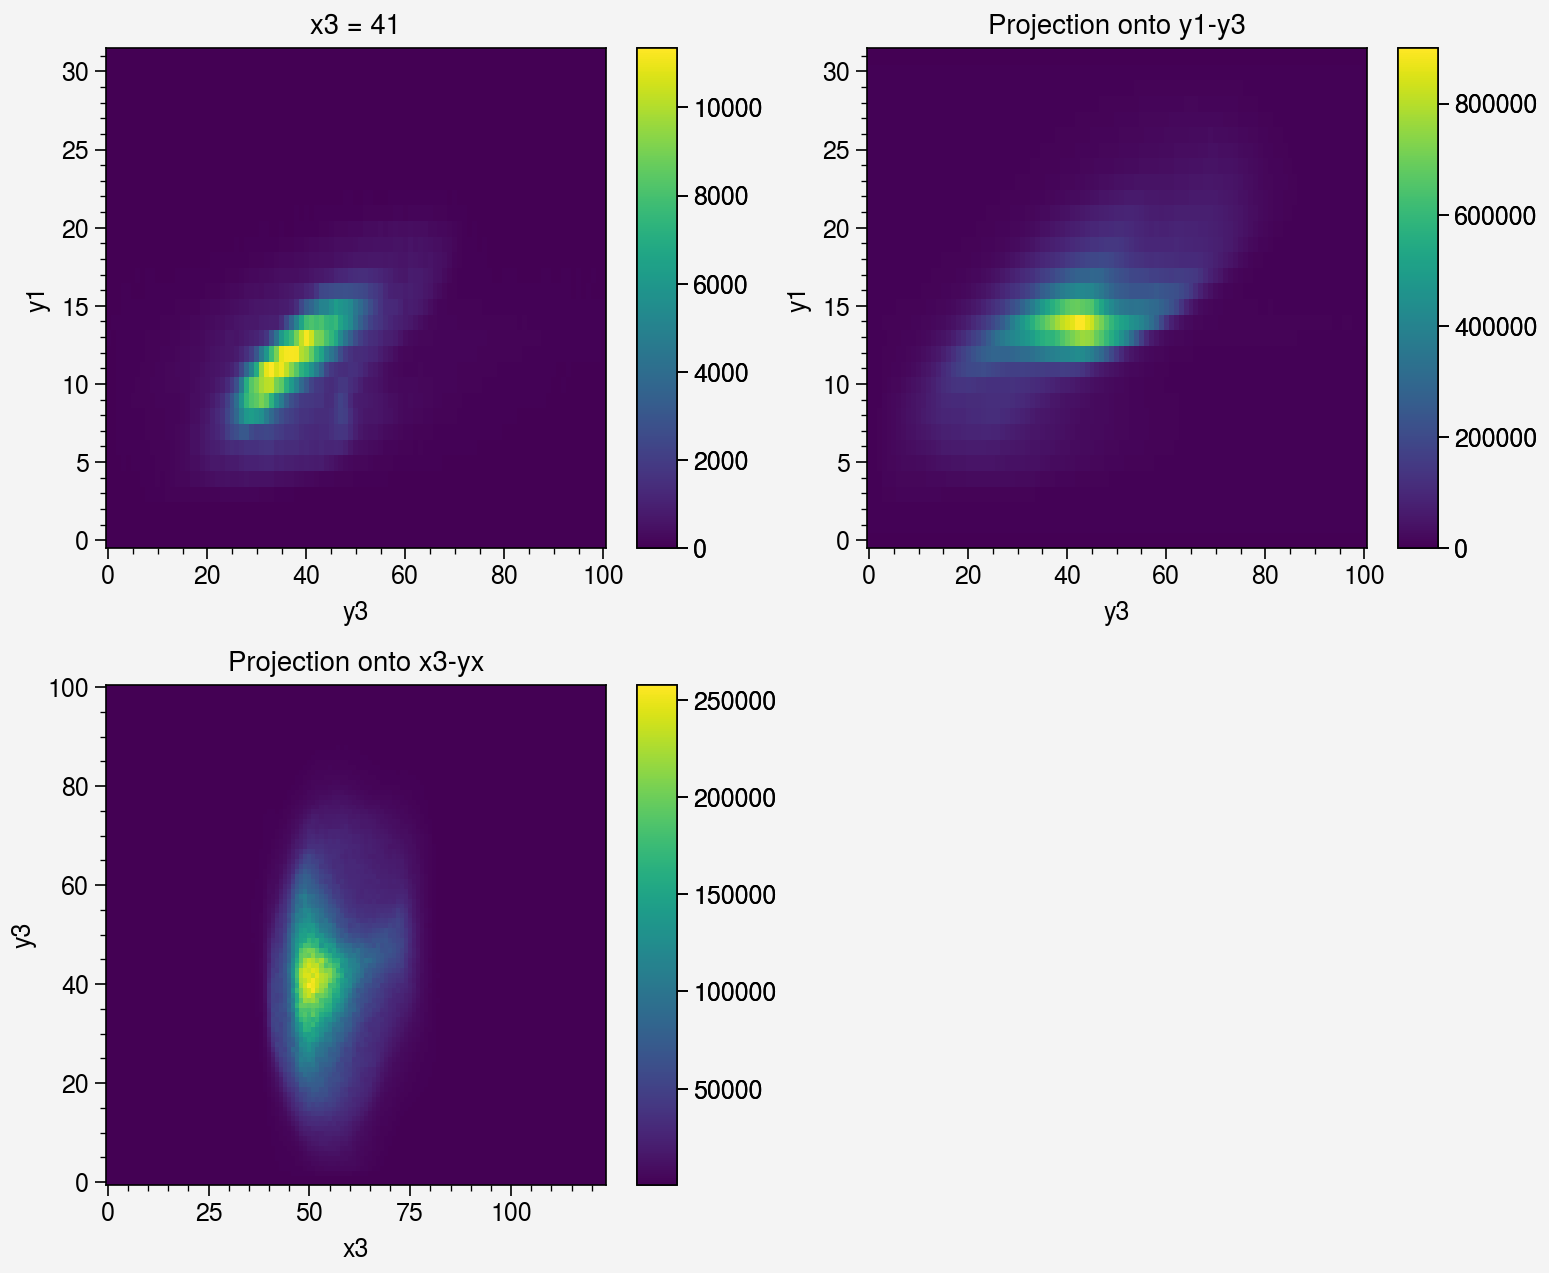

In [113]:
plot_kws = dict(discrete=False, colorbar=True)
fig, axes = pplt.subplots(nrows=2, ncols=2, sharex=False, sharey=False)
x3 = nx // 3
axes[0].pcolormesh(a3d[:, :, x3], **plot_kws)
axes[0].format(xlabel='y3', ylabel='y1', title=f'x3 = {x3}')
axes[1].pcolormesh(a3d.sum(axis=2), **plot_kws)
axes[1].format(xlabel='y3', ylabel='y1', title='Projection onto y1-y3')
axes[2].pcolormesh(a3d.sum(axis=0), **plot_kws)
axes[2].format(xlabel='x3', ylabel='y3', title='Projection onto x3-yx')
axes[3].axis('off')
plt.show()

## Save 5D array as memory map 

In [127]:
crop_shape = tuple([len(GV[2]), len(GV[1])] + list(a3d.shape))
crop_shape

(33, 33, 32, 101, 124)

In [150]:
arrays_3d = np.memmap(savefilename, shape=crop_shape, dtype='float', mode='w+') 
for i in trange(len(GV[2])):
    for j in range(len(GV[1])):
        try:
            idx = idx_bin[POINTS2D[i, j] - 1]
            arrays_3d[i, j, :, :, :] = get_image_3d(idx, ygrid, ny, nx)
        except IndexError:
            print(f'No points in grid bin ({i}, {j})')
            arrays_3d[i, j, :, :, :] = 0
                  
# savefilename = f'rawgrid_{filename}.mmp'
# np.save(savefilename, arrays_3d)
# np.savez_compressed(
#     savefilename, 
#     a3d=arrays_3d, 
#     x1gv=GV[2], 
#     x2gv=GV1[1], 
#     M=M, 
#     centers=centers, 
#     y1gv=ygrid
# )
del arrays_3d

  0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_2840433/2319931311.py:5: RuntimeWarning: overflow encountered in long_scalars
  idx = idx_bin[POINTS2D[i, j] - 1]


No points in grid bin (0, 0)
No points in grid bin (0, 1)


100%|██████████| 33/33 [02:13<00:00,  4.05s/it]

No points in grid bin (32, 32)


## Visualization
Remember, grid coordinates are in normalized frame

In [151]:
a5d = np.memmap(savefilename, shape=crop_shape, dtype='float', mode='r')

### Slices across beam center

In [170]:
a5d_max = np.max(a5d)
ind_max = utils.max_indices(a5d)
ix1, ix2, iy1, iy2, ix3 = ind_max
print(f'Peak value = {a5d_max} at index {ind_max}')

Peak value = 114632.0 at index (22, 18, 13, 39, 43)


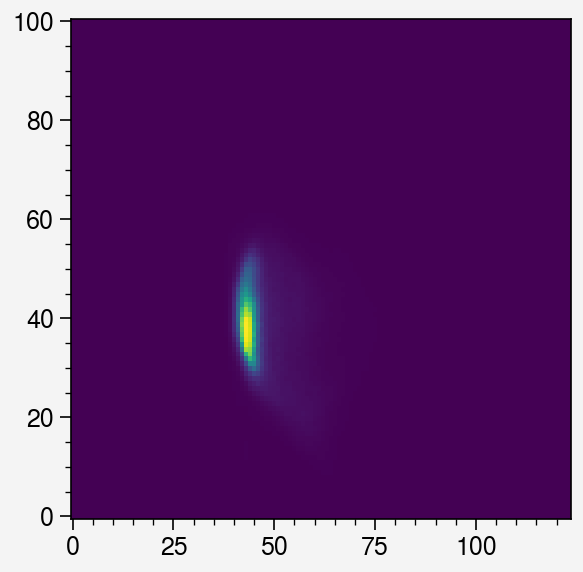

In [173]:
im = a5d[ix1, ix2, iy1].copy()

fig, ax = pplt.subplots()
ax.pcolormesh(im)

In [140]:
im = a5d[ix1, ix2, iy1, :, :]

# fig, ax = pplt.subplots()
# ax.pcolormesh(im)
# labels=['x3', 'y3']
# nx = np.shape(ima)[1]
# ny = np.shape(ima)[0]

# plt.figure(figsize=[12,5])
# plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
# plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()



IndexError: index 90 is out of bounds for axis 1 with size 33

In [ ]:
ima = a5d[ix1,ix2,:,iy2,:].copy()
labels=['x3','y1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()





In [ ]:
ima = a5d[ix1,:,iy1,iy2,:].copy()
labels=['x3','x2']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()


In [ ]:
ima = a5d[:,ix2,iy1,iy2,:].copy()
labels=['x3','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()

In [ ]:
ima = a5d[:,:,iy1+2,iy2,ix3].copy()
labels=['x2','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()

In [ ]:
ima = a5d[ix1,ix2,:,:,ix3].copy()
labels=['y2','y1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()

In [ ]:
ima = a5d[:,ix2,:,iy2,ix3].copy()
labels=['y1','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()


### Projections

Note: this is without threshold applied, so backgrounds are elevated.

In [ ]:
# (ix1,ix2,iy1,iy2,ix3)
ima = a5d.sum(axis=1).sum(axis=2).sum(axis=2)
labels=['y1','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()


In [ ]:
# (ix1,ix2,iy1,iy2,ix3)
ima = a5d.sum(axis=2).sum(axis=2).sum(axis=2)
labels=['x2','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()



In [ ]:
# (ix1,ix2,iy1,iy2,ix3)
ima = a5d.sum(axis=0).sum(axis=0).sum(axis=2)
labels=['y2','y1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()



In [ ]:
# (ix1,ix2,iy1,iy2,ix3)
ima = a5d.sum(axis=0).sum(axis=1).sum(axis=2)
labels=['y3','x2']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()


In [ ]:
# (ix1,ix2,iy1,iy2,ix3)
ima = a5d.sum(axis=1).sum(axis=1).sum(axis=1)
labels=['x3','x1']
nx = np.shape(ima)[1]
ny = np.shape(ima)[0]

plt.figure(figsize=[12,5])
plt.subplot(121); plot_image(ima,log=False,nx_=nx,ny_=ny,labels=labels); 
plt.subplot(122); plot_image(ima,log=True,nx_=nx,ny_=ny,labels=labels); plt.colorbar()



In [ ]:
del a5d